In [1]:
# Imports 
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ['pyna_language'] = 'python'
from pyNA.pyna import pyna

In [119]:
# Functions 
def read_control(file_name):
    
    with open(file_name) as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        lines[i] = lines[i].replace("\n", "")

    # Extract var
    idx_i = [i for i,s in enumerate(lines) if "[" in s]
    idx_e = [i for i,s in enumerate(lines) if "]" in s]

    var = np.zeros((len(idx_i), 88))

    for i in np.arange(np.size(idx_i)):

        line = ''
        for x in np.arange(idx_i[i], idx_e[i]+1, 1):
            line += lines[x]

        var[i,:] = np.fromstring(line[1:-1], sep=' ')

    return var

def read_optimizer_control_inputs(directory_name = ''):

    file_name_k          = directory_name + 'inputs_k.txt'
    file_name_alpha      = directory_name + 'inputs_alpha.txt'
    file_name_TS         = directory_name + 'inputs_TS.txt'
    file_name_theta      = directory_name + 'inputs_theta_flaps.txt'
    file_name_levels_int = directory_name + 'outputs_levels_int.txt'
    
    return_lst = []
    
    # Read objective function
    with open(file_name_levels_int) as f:
        lines_lvl = f.readlines()

    # Extract EPNL
    levels_int = np.zeros((len(lines_lvl), 2))
    for i, line in enumerate(lines_lvl):
        levels_int[i,:] = np.fromstring(line[1:-2], sep=', ')

    return_lst.append(levels_int)
    
    try:
        # Read k
        with open(file_name_k) as f:
            lines_k = f.readlines()

        # Extract TS
        k = np.zeros(len(lines_k))
        for i, line in enumerate(lines_k):
            k[i] = line
        
        return_lst.append(k)
    except:
        pass
        
    try:
        return_lst.append(read_control(file_name_alpha))
    except:
        pass
    
    try:
        return_lst.append(read_control(file_name_TS))
    except:
        pass
        
    try:
        return_lst.append(read_control(file_name_theta))
    except:
        pass
    
    return return_lst

def plot_optimizer_control_inputs(levels_int, k=None, alpha=None, TS=None, theta=None, epnl_constraint=100.):
    
    nvars = 1
    if np.size(k) > 1:
        nvars = nvars + 1    
    if np.size(alpha) > 1:
        nvars = nvars + 1
    if np.size(TS) > 1:
        nvars = nvars + 1
    if np.size(theta) > 1:
        nvars = nvars + 1
    
    # Plot
    fig, ax = plt.subplots(nvars,2,figsize=(16,3.1*nvars))
    plt.style.use('../utils/plot.mplstyle')

    # 1. Objective    
    ax[0,0].plot(np.linspace(0, data['iter'].values[-1], np.size(levels_int[:,0])), levels_int[:,0], color='tab:blue')
    ax[0,0].grid(True)
    ax[0,0].set_xlabel('Iteration number [-]')
    ax[0,0].set_ylabel('$EPNL_{lateral}$ \n [EPNdB]')
    
    ax[0,1].plot(np.linspace(0, data['iter'].values[-1], np.size(levels_int[:,1])), levels_int[:,1])
    ax[0,1].grid(True)
    ax[0,1].set_xlabel('Iteration number [-]')
    ax[0,1].set_ylabel('$EPNL_{flyover}$ \n [EPNdB]')
        
    # 2. alpha
    if np.size(TS) > 1:
        for i in np.arange(np.shape(alpha)[1]):
            ax[1,0].plot(np.linspace(0, data['iter'].values[-1], np.size(alpha[:,i])), alpha[:,i])
        ax[1,0].set_ylabel(r'$\alpha_i$ [deg]')
        ax[1,0].set_xlabel('Iteration number [-]')

        N = 200
        ax[1,1].plot(alpha[-1,:], '-', label='Final iteration')
        ax[1,1].plot(np.mean(alpha[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[1,1].set_xlabel('$t_{source}$ [s]')
        ax[1,1].set_ylabel(r'$\alpha$ [deg]')
        ax[1,1].legend(fontsize=14, frameon=False)
    
    # 3. Thrust setting
    if np.size(TS) > 1:
        for i in np.arange(np.shape(TS)[1]):
            ax[2,0].plot(np.linspace(0, data['iter'].values[-1], np.size(TS[:,i])), TS[:,i])
        ax[2,0].set_ylabel('$TS_i$ [-]')
        ax[2,0].set_xlabel('Iteration number [-]')

        N = 200
        ax[2,1].plot(TS[-1,:], '-', label='Final iteration')
        ax[2,1].plot(np.mean(TS[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[2,1].set_xlabel('$t_{source}$ [s]')
        ax[2,1].set_ylabel('TS [-]')
        ax[2,1].legend(fontsize=14, frameon=False, loc='upper right')

    # 4. Rotation speed ratio
    if np.size(k) > 1:
        ax[3,0].plot([0, data['iter'].values[-1]], [np.mean(k[-50:]), np.mean(k[-50:])], color='tab:orange', ls='--')
        ax[3,0].plot(np.linspace(0, data['iter'].values[-1], np.size(k)), k, color='tab:blue')
        ax[3,0].set_xlabel('Iteration number [-]')
        ax[3,0].set_ylabel('$k_{rot}$ [-]')
        ax[3,1].axis('off')

    # 5. Flap deflection angle
    if np.size(theta) > 1:
        for i in np.arange(np.shape(theta)[1]):
            ax[4,0].plot(np.linspace(0, data['iter'].values[-1], np.size(theta[:,i])), theta[:,i])

        ax[4,0].set_ylabel(r'$\theta$ [deg]')
        ax[4,0].set_xlabel('Optimization iteration N')

        ax[4,1].plot(theta[-1,:], '-', label='Final iteration')
        ax[4,1].plot(np.mean(theta[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[4,1].set_xlabel('$t_{source}$ [s]')
        ax[4,1].set_ylabel(r'$\theta$ [deg]')
        ax[4,1].grid(True)


    plt.subplots_adjust(wspace=0.3, hspace=0.55)

    return 

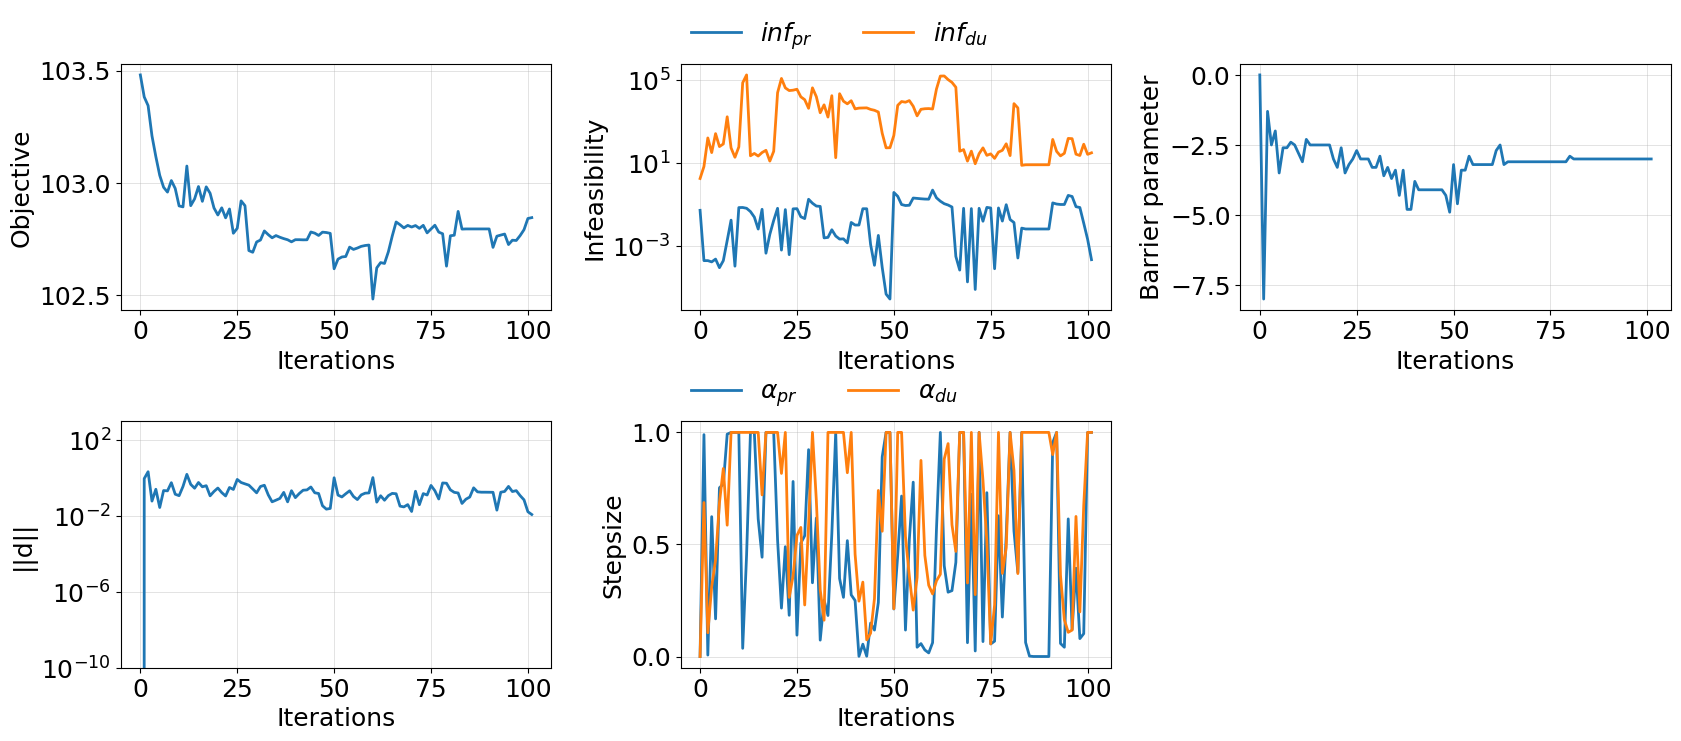

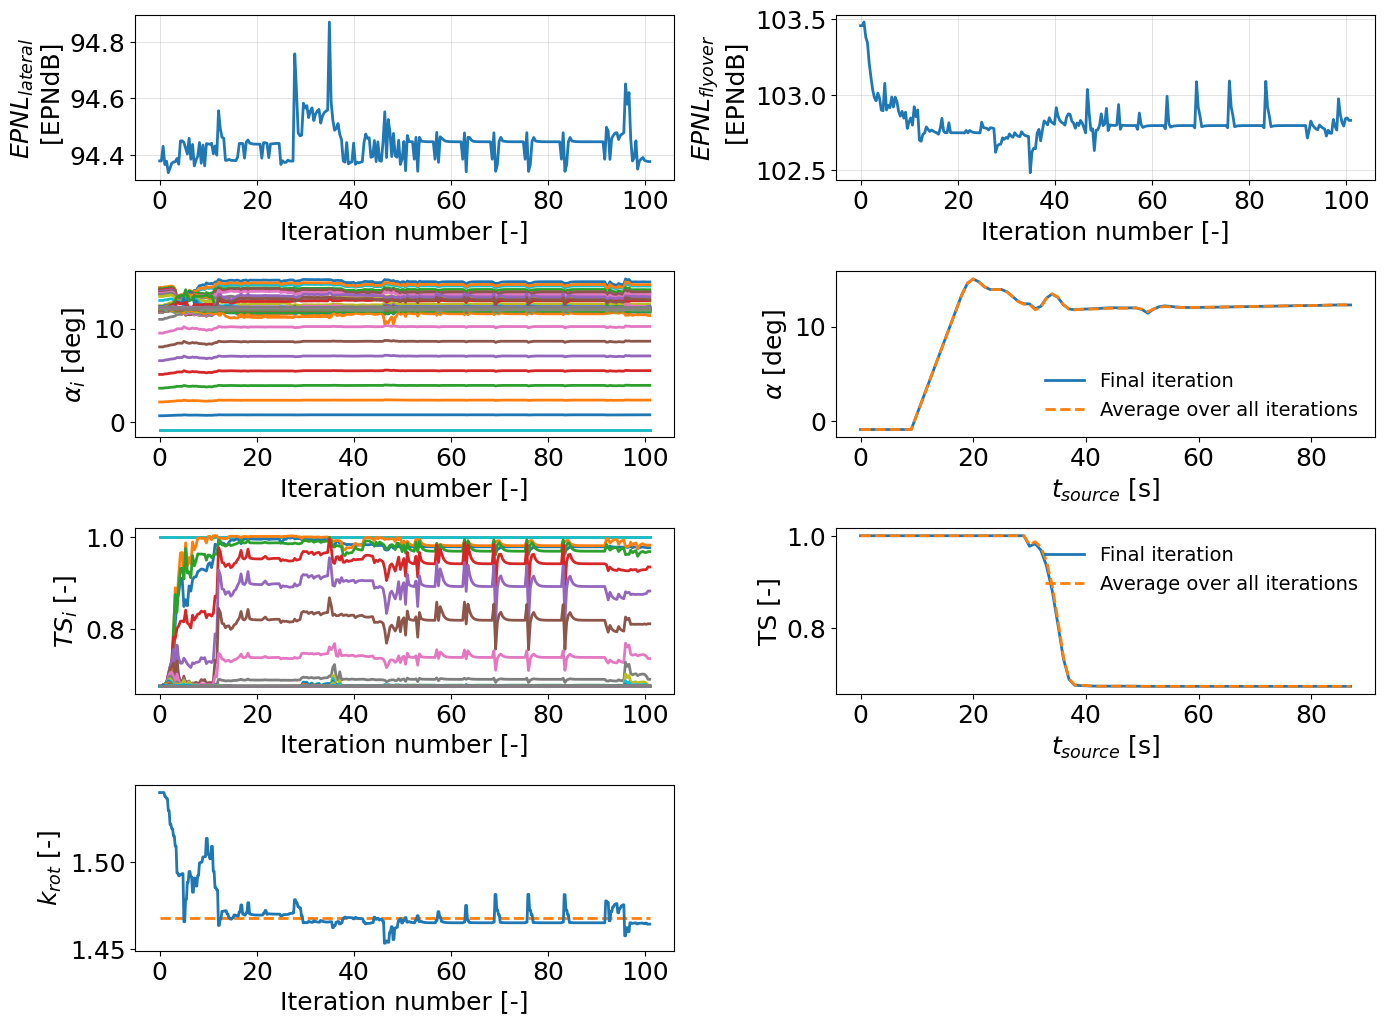

In [124]:
# IPOPT output 
directory_name = '../cases/a10/output/PTCB/Vmax/'

# Load files
levels_int, k, alpha, TS, theta = read_optimizer_control_inputs(directory_name)

py = pyna()
data = py.plot_optimizer_convergence_data(directory_name + 'IPOPT_trajectory_convergence.out')
plot_optimizer_control_inputs(levels_int, k, alpha, TS, epnl_constraint=93.75536407)